In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
# Generate synthetic time series data with daily seasonality
np.random.seed(42)
n = 365  # Number of data points
t = np.arange(n)
seasonality = 7  # Weekly seasonality
data = 50 + 10 * np.sin(2 * np.pi * t / seasonality) + np.random.normal(0, 5, n)

# Convert the data to a pandas DataFrame
df = pd.DataFrame({'Date': pd.date_range(start='2020-01-01', periods=n), 'Value': data})
df.set_index('Date', inplace=True)

# Create Fourier terms for weekly seasonality
def create_fourier_terms(t, period, num_terms):
    terms = []
    for i in range(1, num_terms + 1):
        terms.append(np.sin(2 * np.pi * i * t / period))
        terms.append(np.cos(2 * np.pi * i * t / period))
    return np.column_stack(terms)

num_fourier_terms = 4
fourier_terms = create_fourier_terms(t, seasonality, num_fourier_terms)

print(fourier_terms)

# Fit the ARIMA model using pmdarima's auto_arima with Fourier terms as exogenous variables
model = auto_arima(df['Value'],exogenous=fourier_terms[:n], seasonal=True, suppress_warnings=True)
model.fit(df['Value'], exogenous=fourier_terms[:n])

# Forecast future values with the fitted model
forecast_steps =30
forecast_exog = create_fourier_terms(np.arange(n, n + forecast_steps), seasonality, num_fourier_terms)

# Get the forecast for the future steps with exogenous variables
forecast_df = pd.DataFrame(forecast_exog, columns=[f'Fourier_{i+1}' for i in range(num_fourier_terms * 2)])
#forecast_values = model.predict(n_periods=forecast_steps)
forecast_values = model.predict(n_periods=forecast_steps, exogenous=forecast_df)

# Retrieve the index for forecasting
forecast_index = pd.date_range(start='2021-01-01', periods=forecast_steps)

# Plot the original data and the forecasted values
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Value'], label='Original Data')
plt.plot(forecast_index, forecast_values, label='Forecasted Values', color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('ARIMA with Fourier Terms Forecast')
plt.legend()
plt.show()

# Seasonal-Trend decomposition using LOESS (STL)

In [ ]:
import numpy as np

rs = np.random.RandomState(0xA4FD94BC)
tau = 2000
t = np.arange(tau)
period = int(0.05 * tau)
seasonal = period + ((period % 2) == 0)  # Ensure odd
e = 0.25 * rs.standard_normal(tau)
y = np.cos(t / tau * 2 * np.pi) + 0.25 * np.sin(t / period * 2 * np.pi) + e
plt.plot(y)
plt.title("Simulated Data")
xlim = plt.gca().set_xlim(0, tau)

In [ ]:

from statsmodels.tsa.stl._stl import STL

mod = STL(y, period=period, seasonal=seasonal)
%timeit mod.fit()
res = mod.fit()
fig = res.plot(observed=False, resid=False)

In [ ]:
res

# Multiple Seasonal-Trend decomposition using LOESS (MSTL)

In [ ]:
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.seasonal import DecomposeResult

register_matplotlib_converters()
sns.set_style("darkgrid")

In [ ]:
plt.rc("figure", figsize=(16, 12))
plt.rc("font", size=13)

In [ ]:
t = np.arange(1, 1000)
daily_seasonality = 5 * np.sin(2 * np.pi * t / 24)
weekly_seasonality = 10 * np.sin(2 * np.pi * t / (24 * 7))
trend = 0.0001 * t**2
y = trend + daily_seasonality + weekly_seasonality + np.random.randn(len(t))
ts = pd.date_range(start="2020-01-01", freq="H", periods=len(t))
df = pd.DataFrame(data=y, index=ts, columns=["y"])

In [ ]:
df.head()


In [ ]:
df["y"].plot(figsize=[10, 5])


In [ ]:

mstl = MSTL(df["y"], periods=[24, 24 * 7])
res = mstl.fit()

In [ ]:
res.seasonal.head()


In [ ]:
ax = res.plot()


# MSTL Using Energy data (Australia)

In [ ]:
url = "https://raw.githubusercontent.com/tidyverts/tsibbledata/master/data-raw/vic_elec/VIC2015/demand.csv"
df = pd.read_csv(url)

In [ ]:

df.head()

In [ ]:
df["Date"] = df["Date"].apply(lambda x: pd.Timestamp("1899-12-30") + pd.Timedelta(x, unit="days"))
df["ds"] = df["Date"] + pd.to_timedelta((df["Period"]-1)*30, unit="m")


In [ ]:
timeseries = df[["ds", "OperationalLessIndustrial"]]
timeseries.columns = ["ds", "y"] # Rename to OperationalLessIndustrial to y for simplicity.

# Filter for first 149 days of 2012.
start_date = pd.to_datetime("2012-01-01")
end_date = start_date + pd.Timedelta("149D")
mask = (timeseries["ds"] >= start_date) & (timeseries["ds"] < end_date)
timeseries = timeseries[mask]

# Resample to hourly
timeseries = timeseries.set_index("ds").resample("H").sum()
timeseries.head()


In [ ]:
mstl = MSTL(timeseries["y"], periods=[24, 24 * 7], iterate=3, stl_kwargs={"seasonal_deg": 0,
                                                                          "inner_iter": 2,
                                                                          "outer_iter": 0})
res = mstl.fit() # Use .fit() to perform and return the decomposition
ax = res.plot()
plt.tight_layout()


In [ ]:
res.seasonal

# Doing the same for out energy data

In [ ]:
from Energy.HelpFunctions.get_energy_data import fetch_energy_data

# fetch_energy_data()

In [ ]:
from Energy.HelpFunctions.get_energy_data import get_energy_data, prepare_data
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

from statsmodels.tsa.seasonal import MSTL

df = get_energy_data()
df = prepare_data(df)

start_date = pd.to_datetime("2020-01-01")
end_date = pd.to_datetime("2023-12-31")

mask = (df.index >= start_date) & (df.index < end_date)
df = df[mask]

In [ ]:
df

In [ ]:
mstl = MSTL(df['gesamt'], periods=[24, 24 * 7], iterate=3)
res = mstl.fit() # Use .fit() to perform and return the decomposition
ax = res.plot()
plt.tight_layout()
plt.savefig(f'../plots/MSLT.png')
plt.show()

In [ ]:
object_methods = [f'{method_name}: {callable(getattr(res, method_name))}' for method_name in dir(res)]

In [ ]:
object_methods

In [ ]:
res.trend

In [ ]:
mstl.forecast()

In [ ]:
from statistics import mean

mean(res.resid)

In [ ]:
plt.plot(res.trend[-5000:])

In [ ]:
d = pd.DataFrame(res.seasonal.seasonal_24[-500:] + res.seasonal.seasonal_168[-500:] + res.trend[-500:])
d.columns = ['24p168_trend']
d['weekly'] = res.seasonal.seasonal_168[-500:]
d['trend'] = res.trend
d['obs'] = df
plt.plot(d)

In [ ]:
d

In [ ]:
# plt.plot(res.resid)

sns.kdeplot(res.resid)

# Forecast using STL

In [ ]:
from sktime.datasets import load_airline
from sktime.forecasting.statsforecast import StatsForecastMSTL

In [ ]:
import pandas as pd
from datetime import timedelta

# Trainind Data start date
start_date = pd.to_datetime("2021-01-01")

# Define the thursdays (after the forecast wednesday). It will then be the end date of the training data
end_dates = ["2022-03-24","2022-03-17","2022-03-10","2022-03-03","2022-02-24","2022-02-17","2022-02-10","2022-02-03","2022-01-27","2022-01-20","2022-01-13","2022-01-06","2023-03-23","2023-03-16","2023-03-09","2023-03-02","2023-02-23","2023-02-16","2023-02-09","2023-02-02","2023-01-26","2022-01-20","2023-01-12","2023-01-05"]

residuals = []

for end_date in end_dates:
    end_date = pd.to_datetime(end_date)
    mask = (df.index >= start_date) & (df.index < end_date)
    y = df[mask]
    model = StatsForecastMSTL(season_length=[24,24*7, 24*364]) 
    fitted_model = model.fit(y=y) 
    
    y_pred = fitted_model.predict(fh=[i for i in range(1,73)]) 
    
    
    start_date_obs = end_date
    end_date_obs = start_date_obs + timedelta(days=3)
    
    mask = (df.index >= start_date_obs) & (df.index < end_date_obs)
    obs = df[mask]
    
    
    import matplotlib.pyplot as plt
    # y.index = y.index.to_timestamp()
    plt.plot(y, color='blue', label='Training')
    
    plt.plot(obs, color='green', label='Observation')
    plt.plot(y_pred, color='orange', label='Prediction')
    plt.legend()
    plt.xticks(rotation=45)
    plt.xlim(pd.to_datetime(end_date-timedelta(days=2)),pd.to_datetime(end_date+timedelta(days=5)))
    plt.show()
    
    res = obs - y_pred
    
    residuals.append(res)
    
    


In [ ]:
res_one_arr = pd.DataFrame()
for res in residuals:
    res_one_arr = pd.concat([res_one_arr, res])
# print(residuals_one_array)

sns.kdeplot(res_one_arr, fill=True)

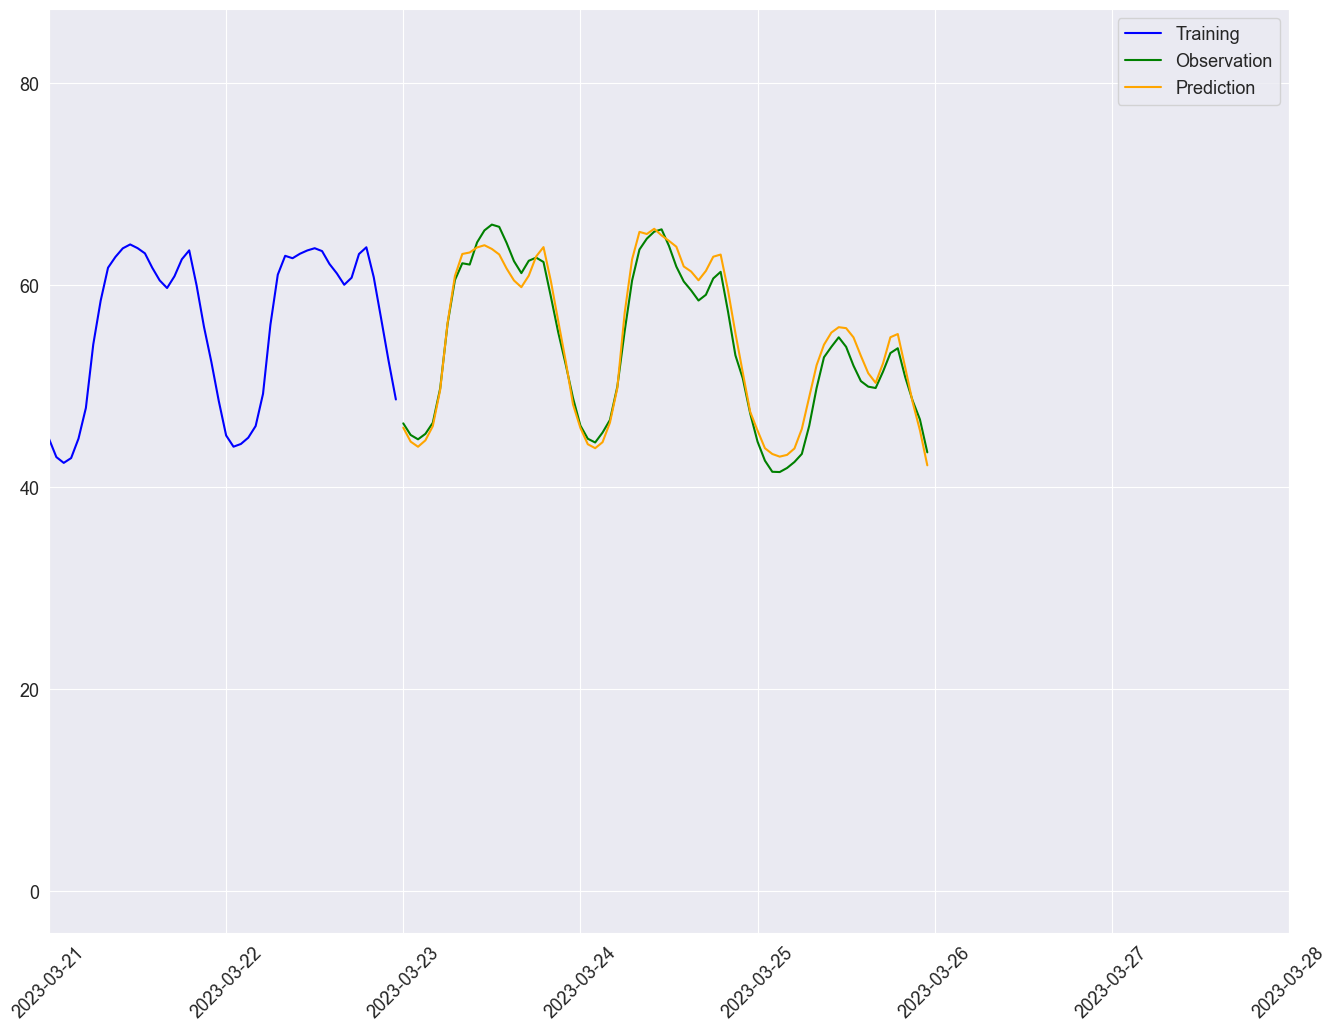

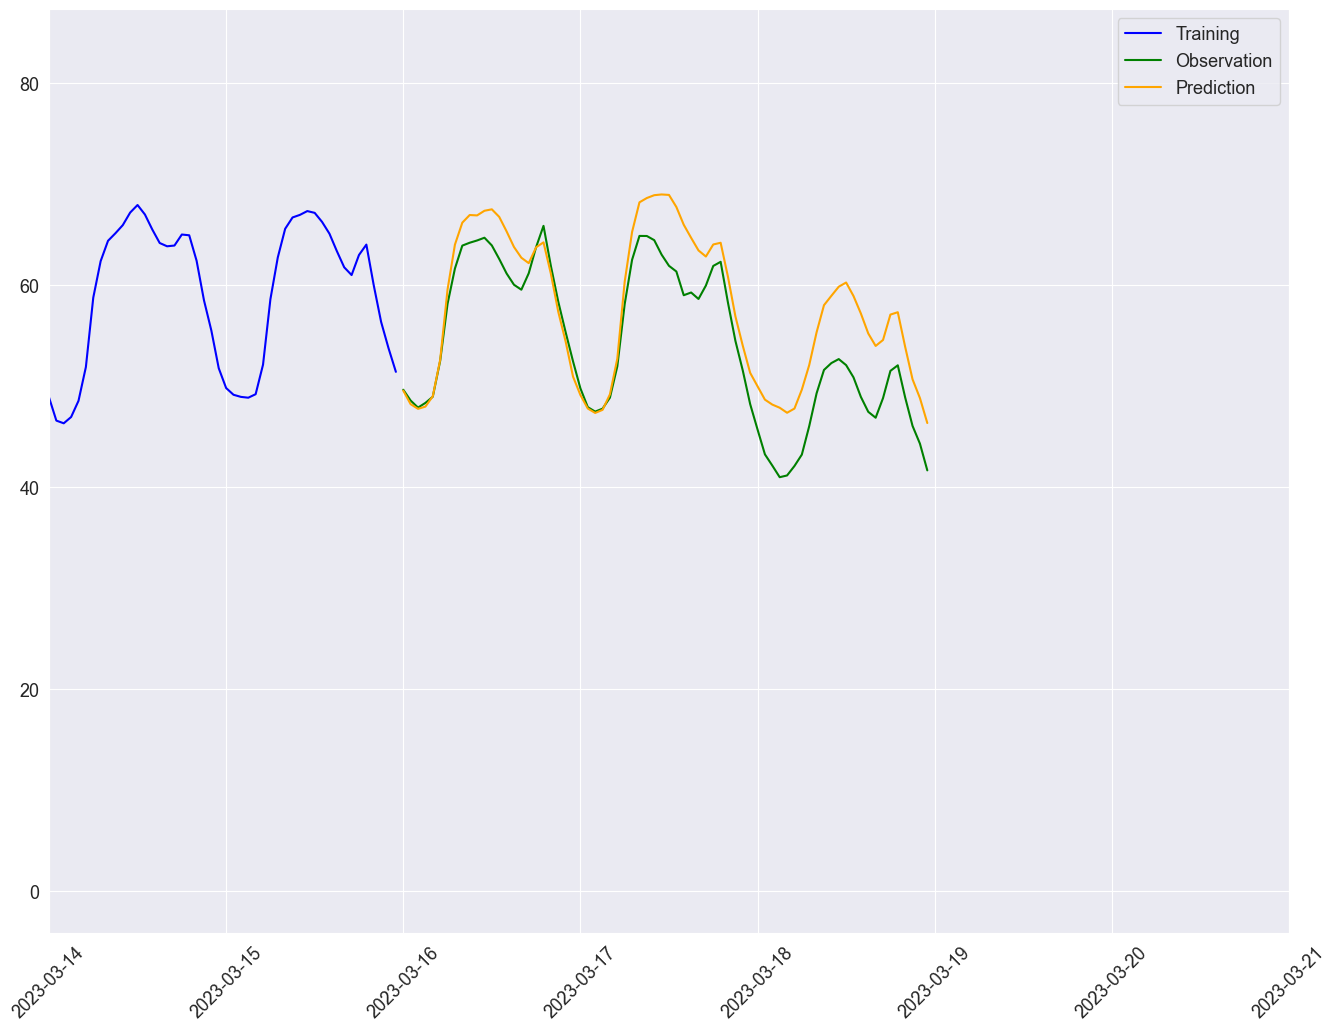

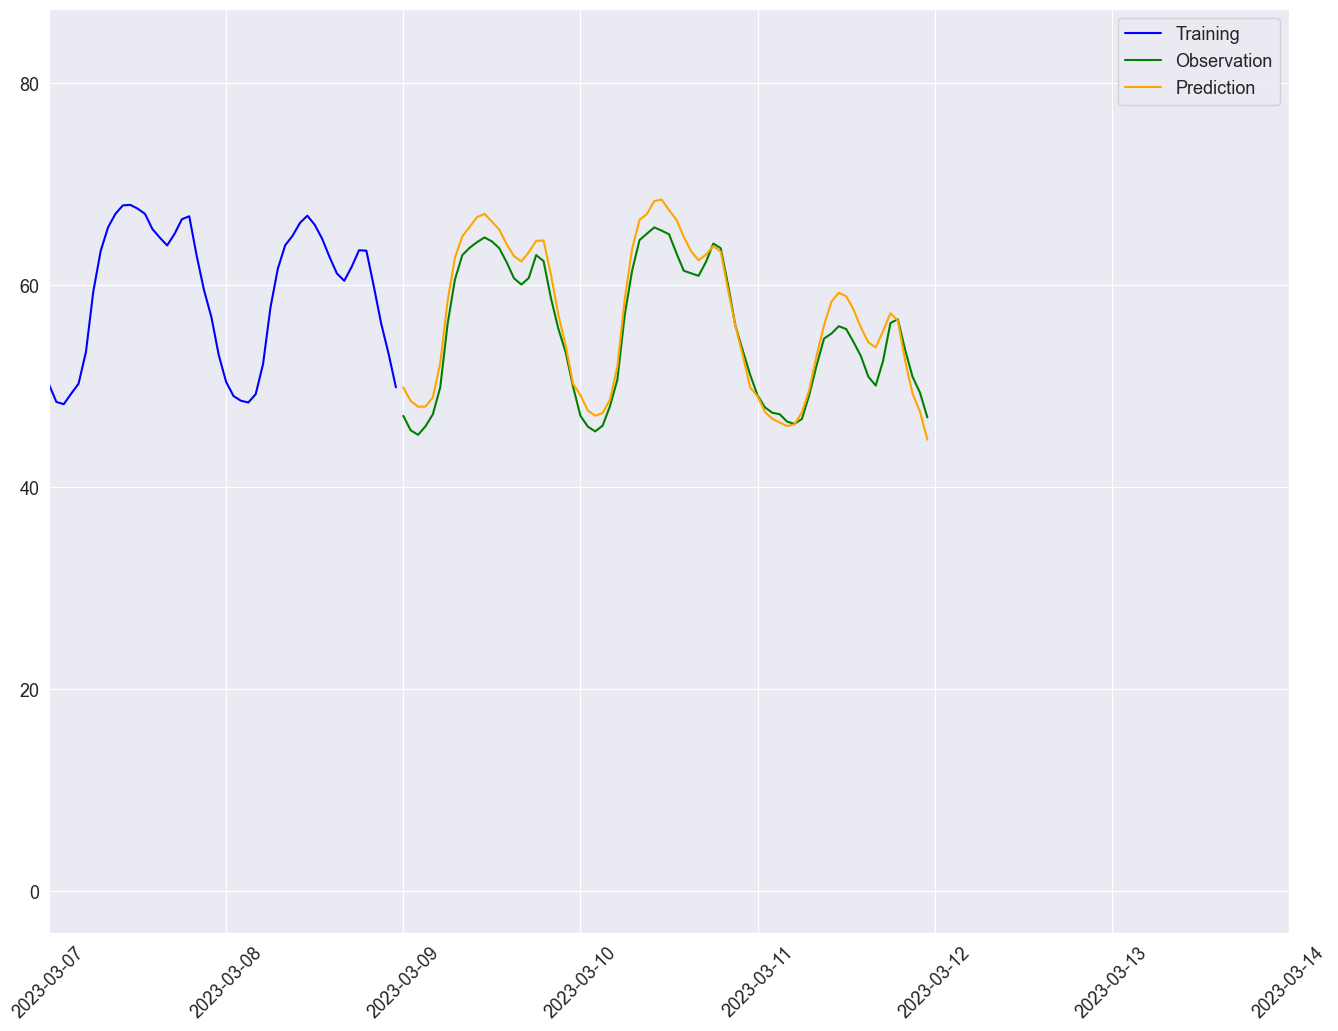

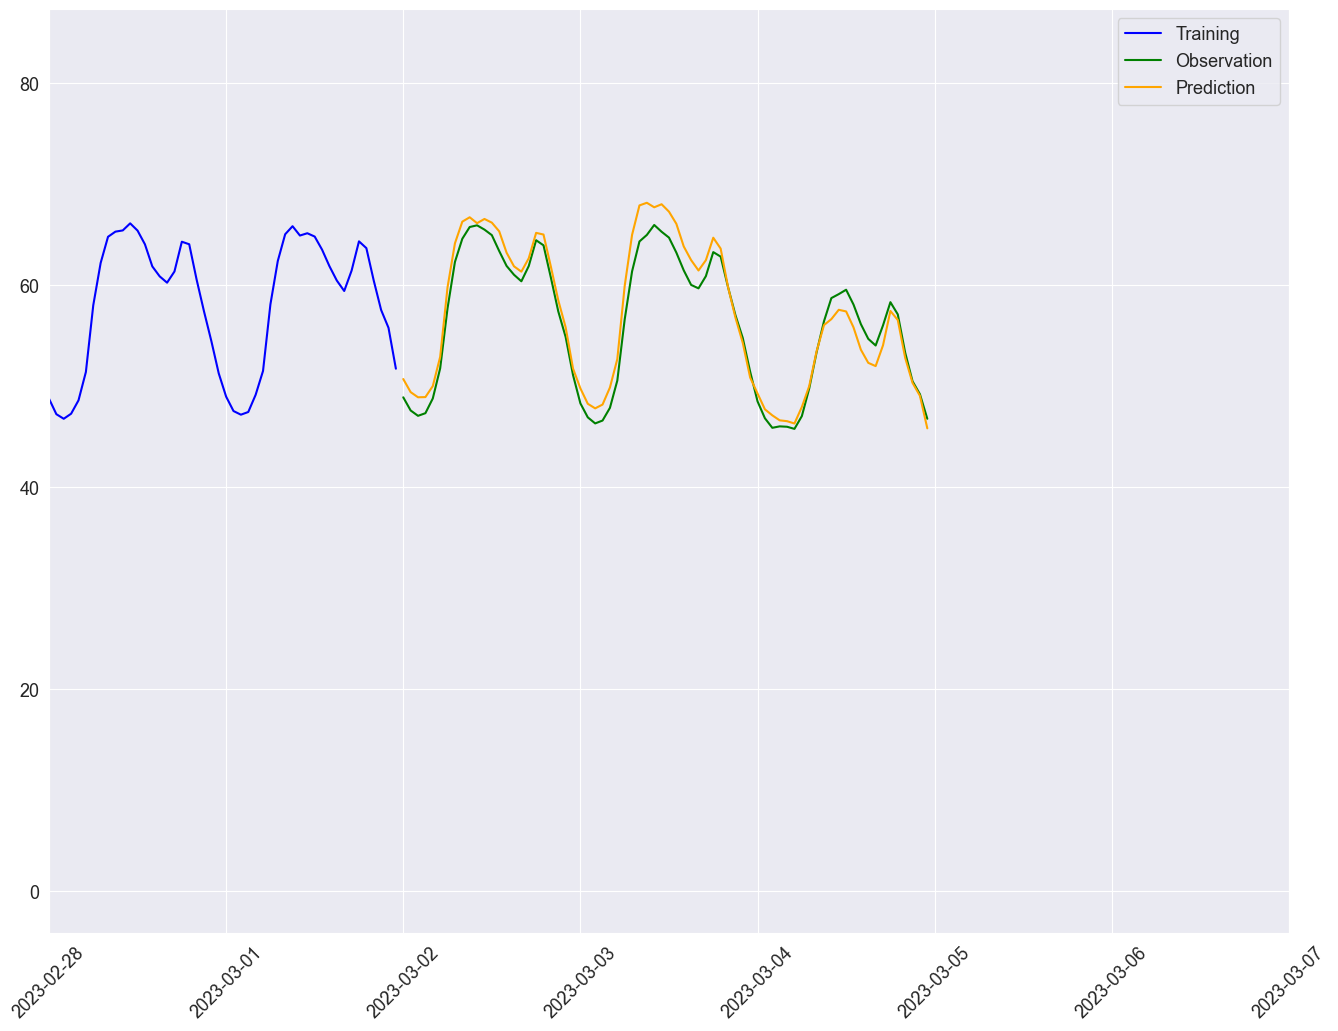

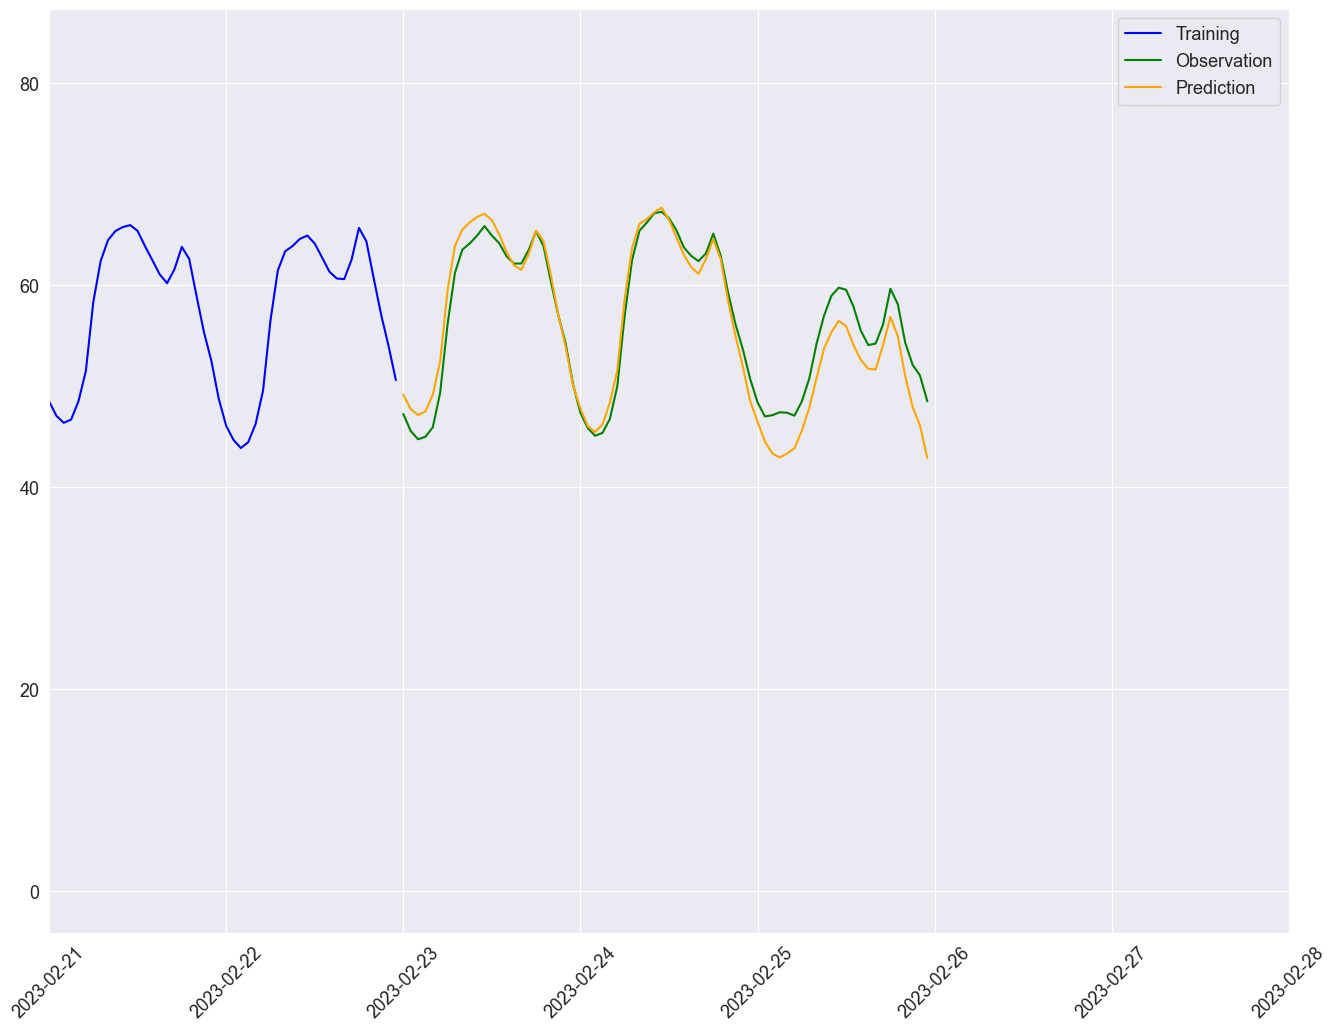

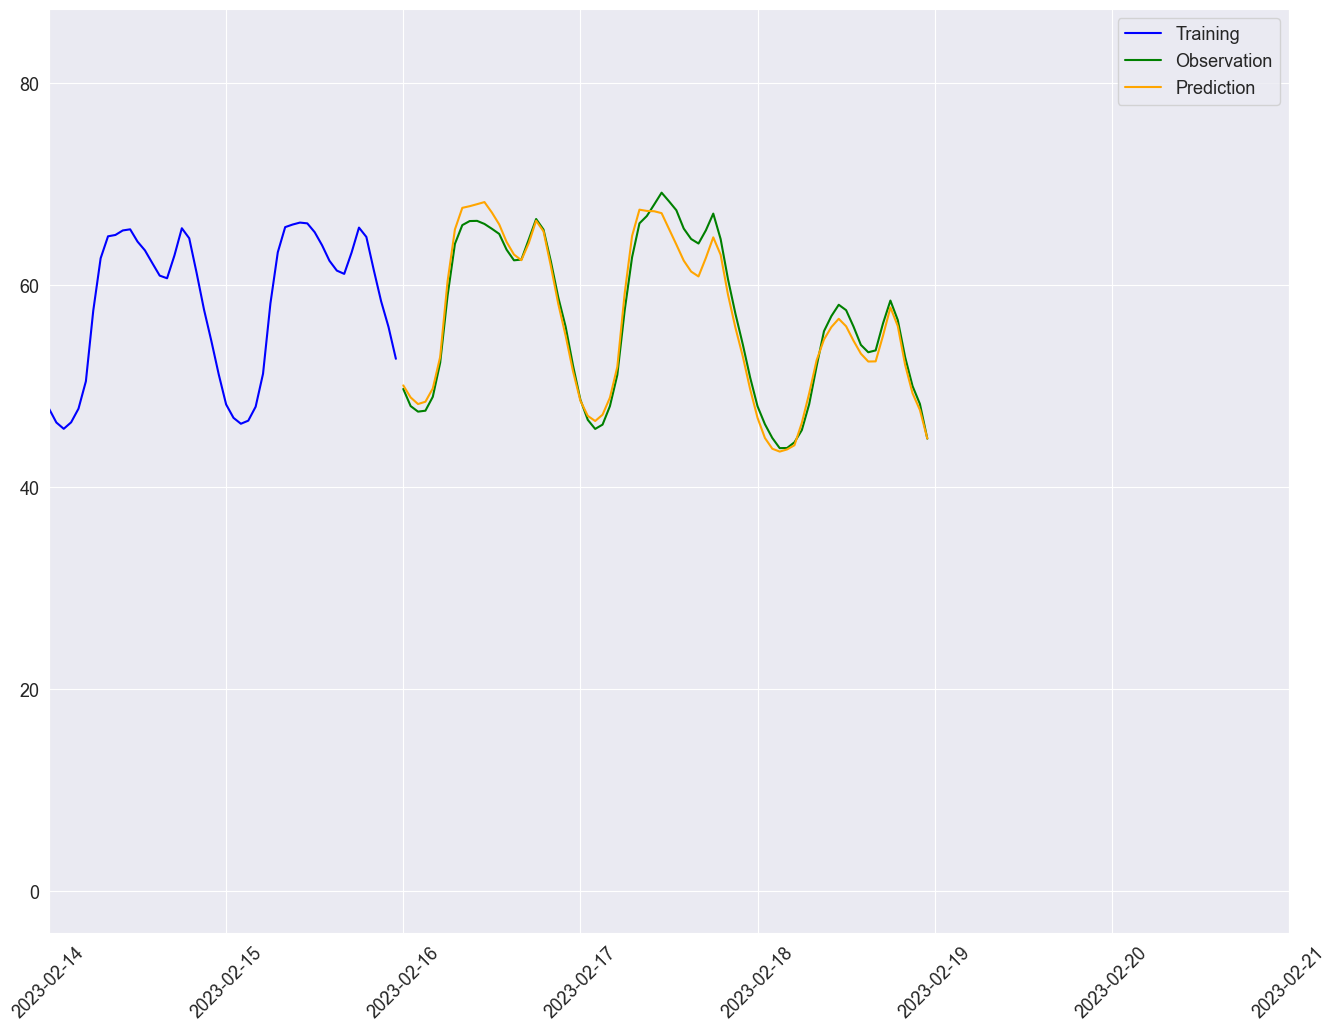

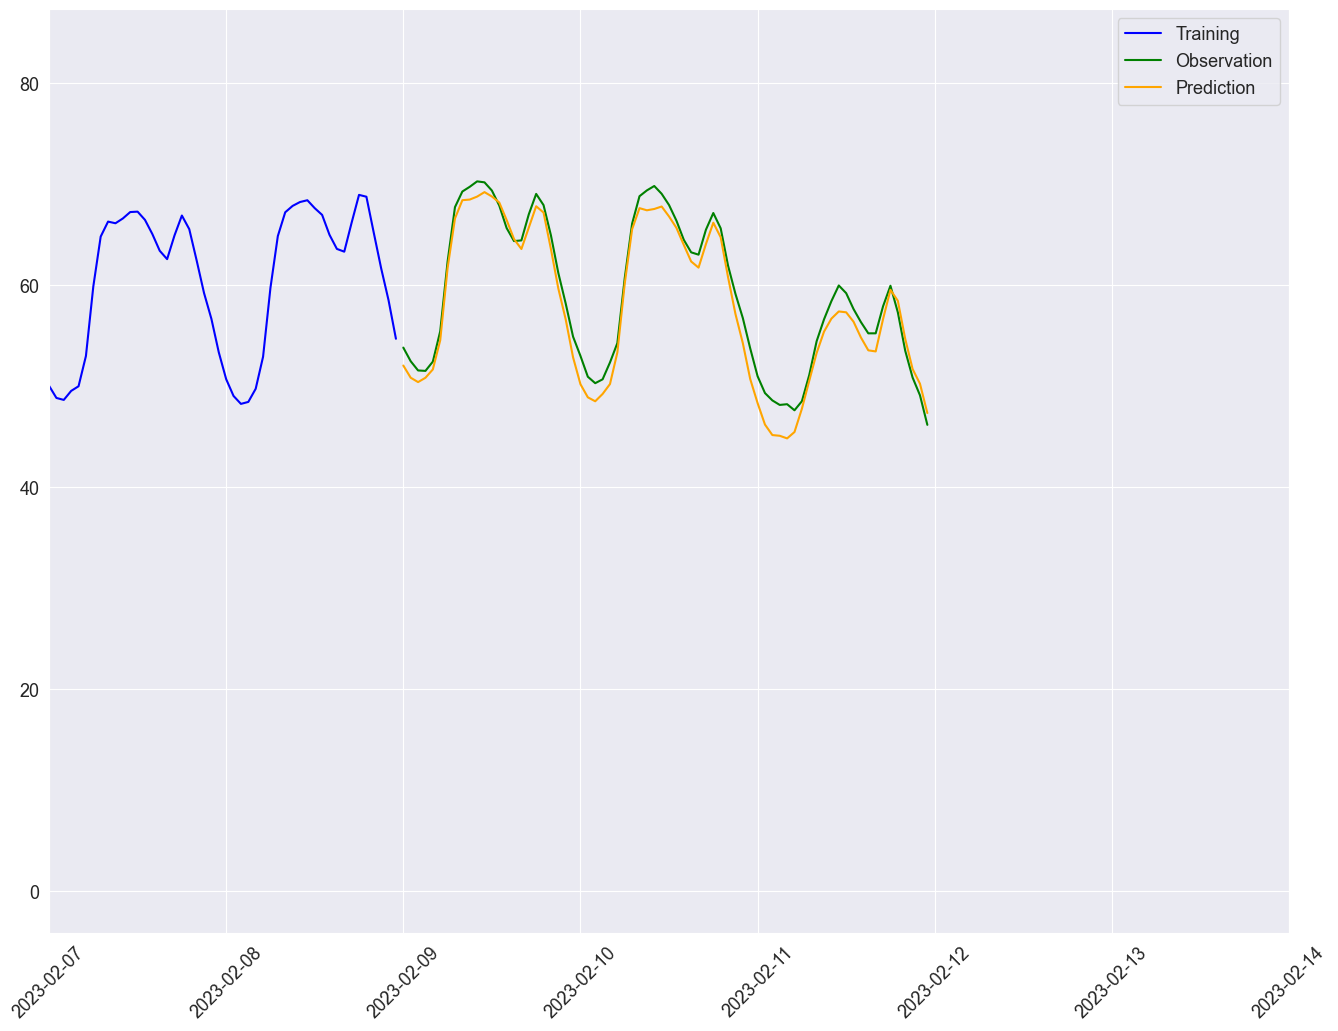

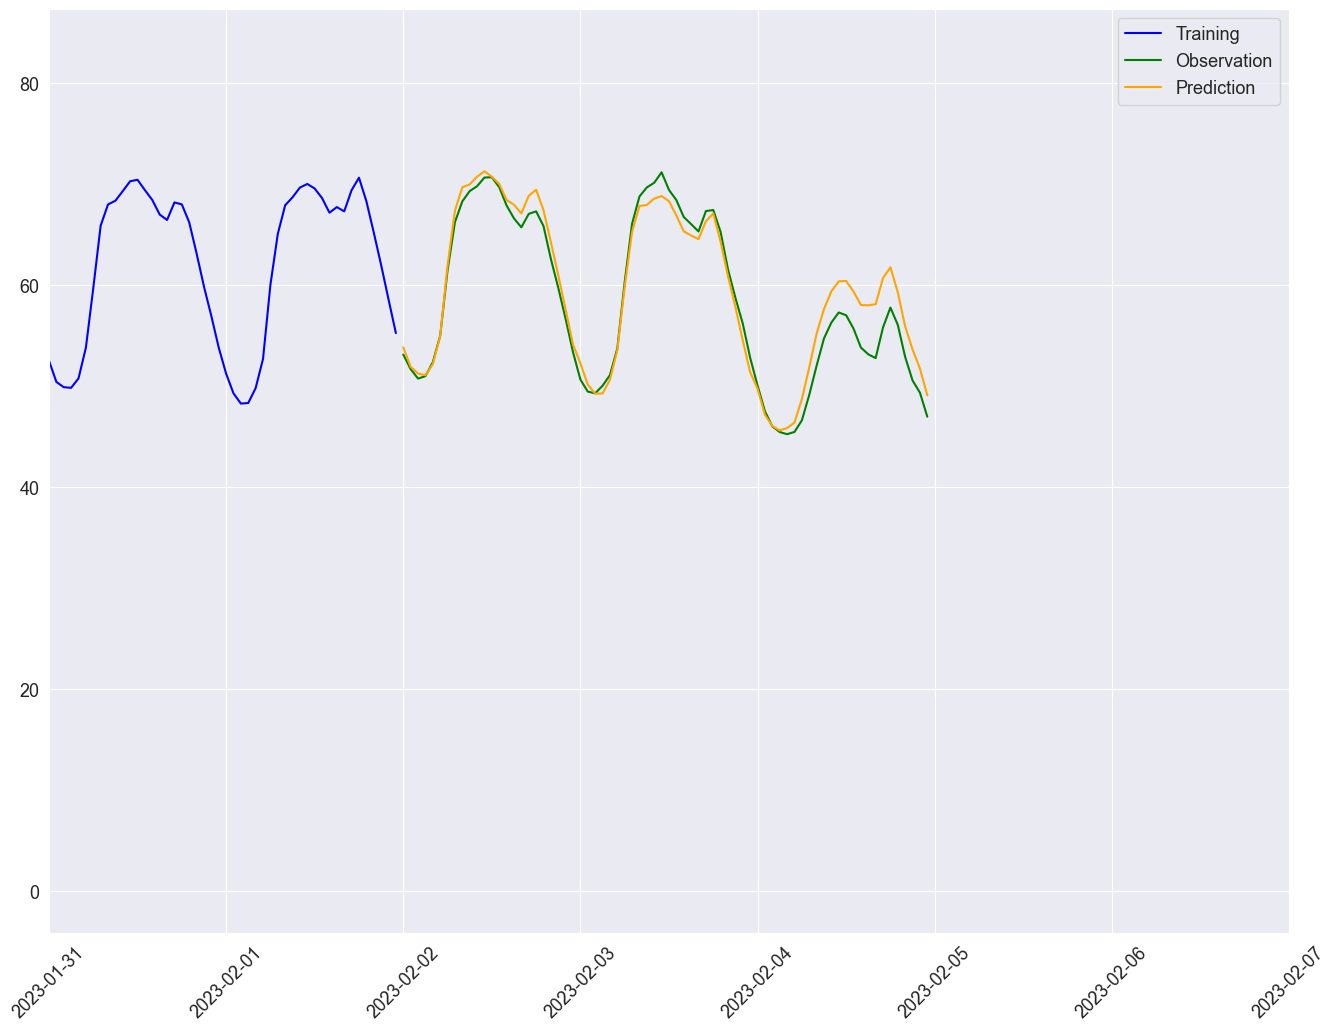

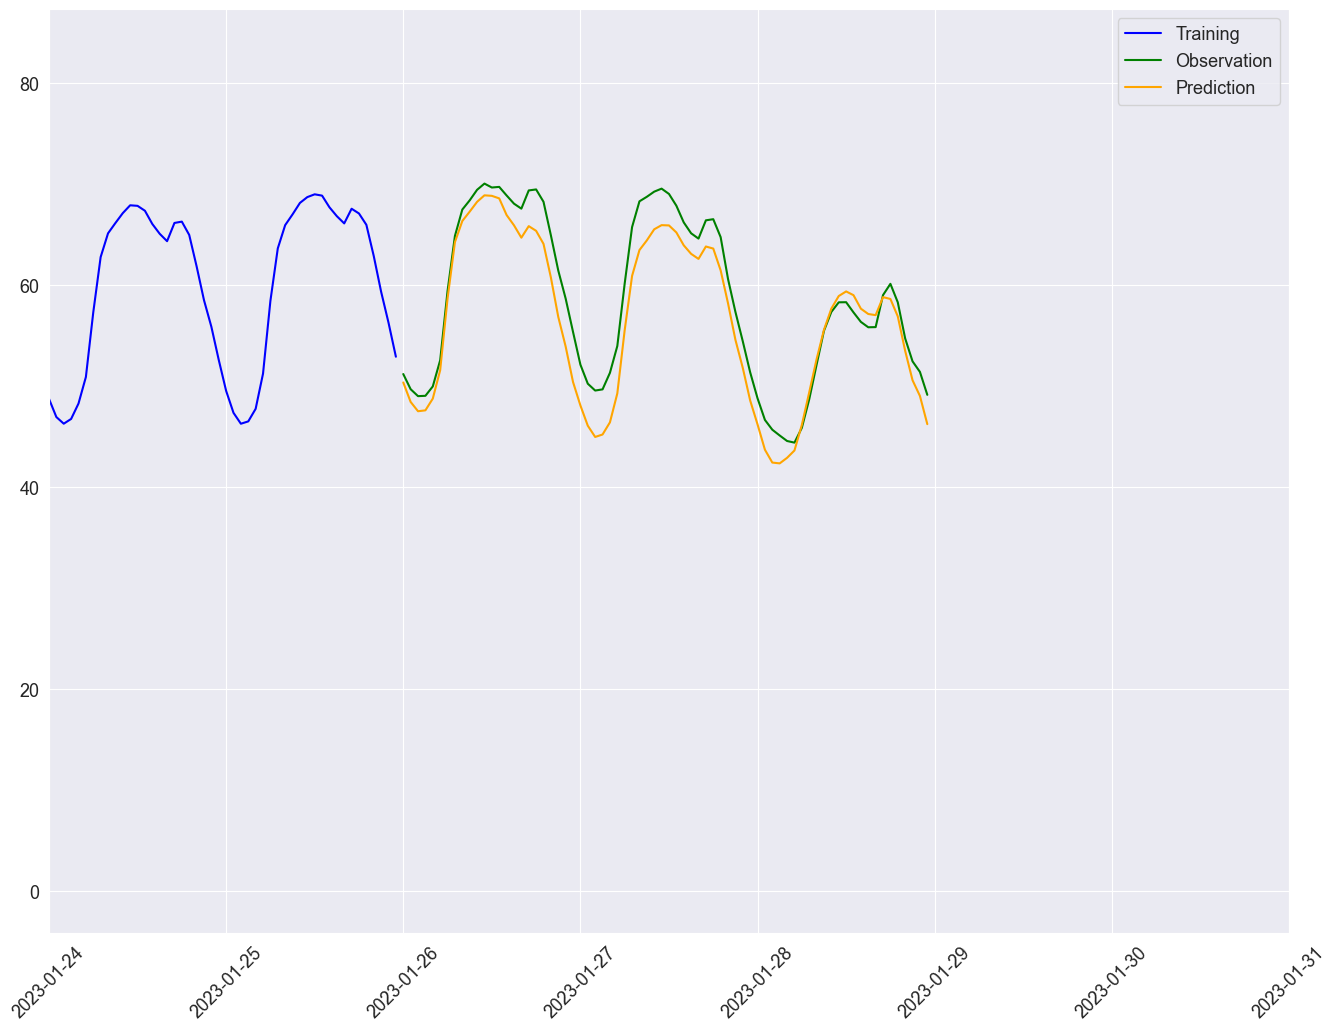

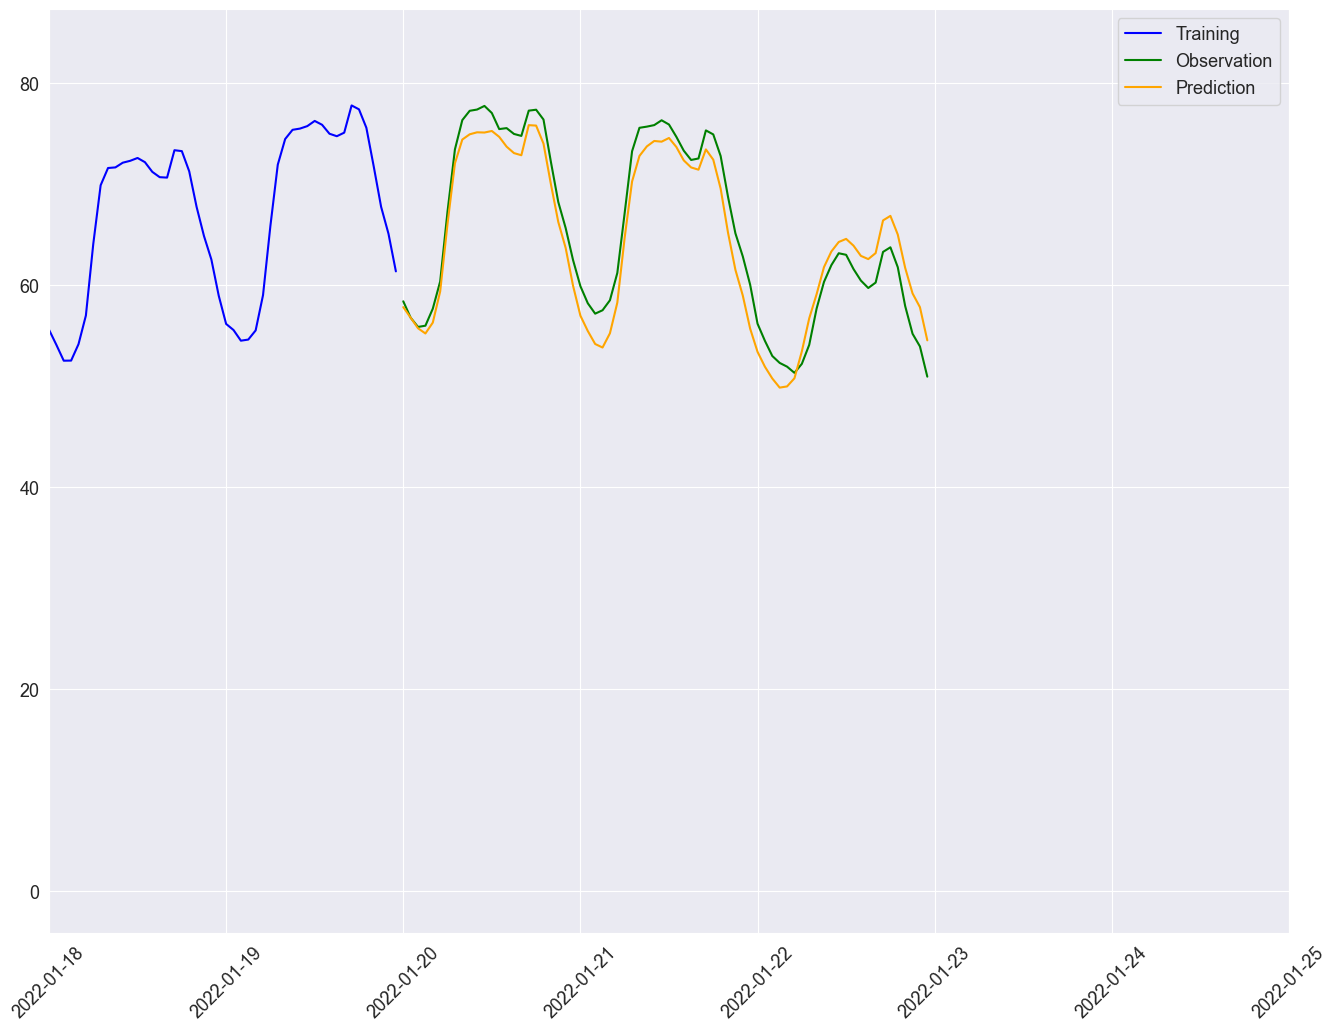

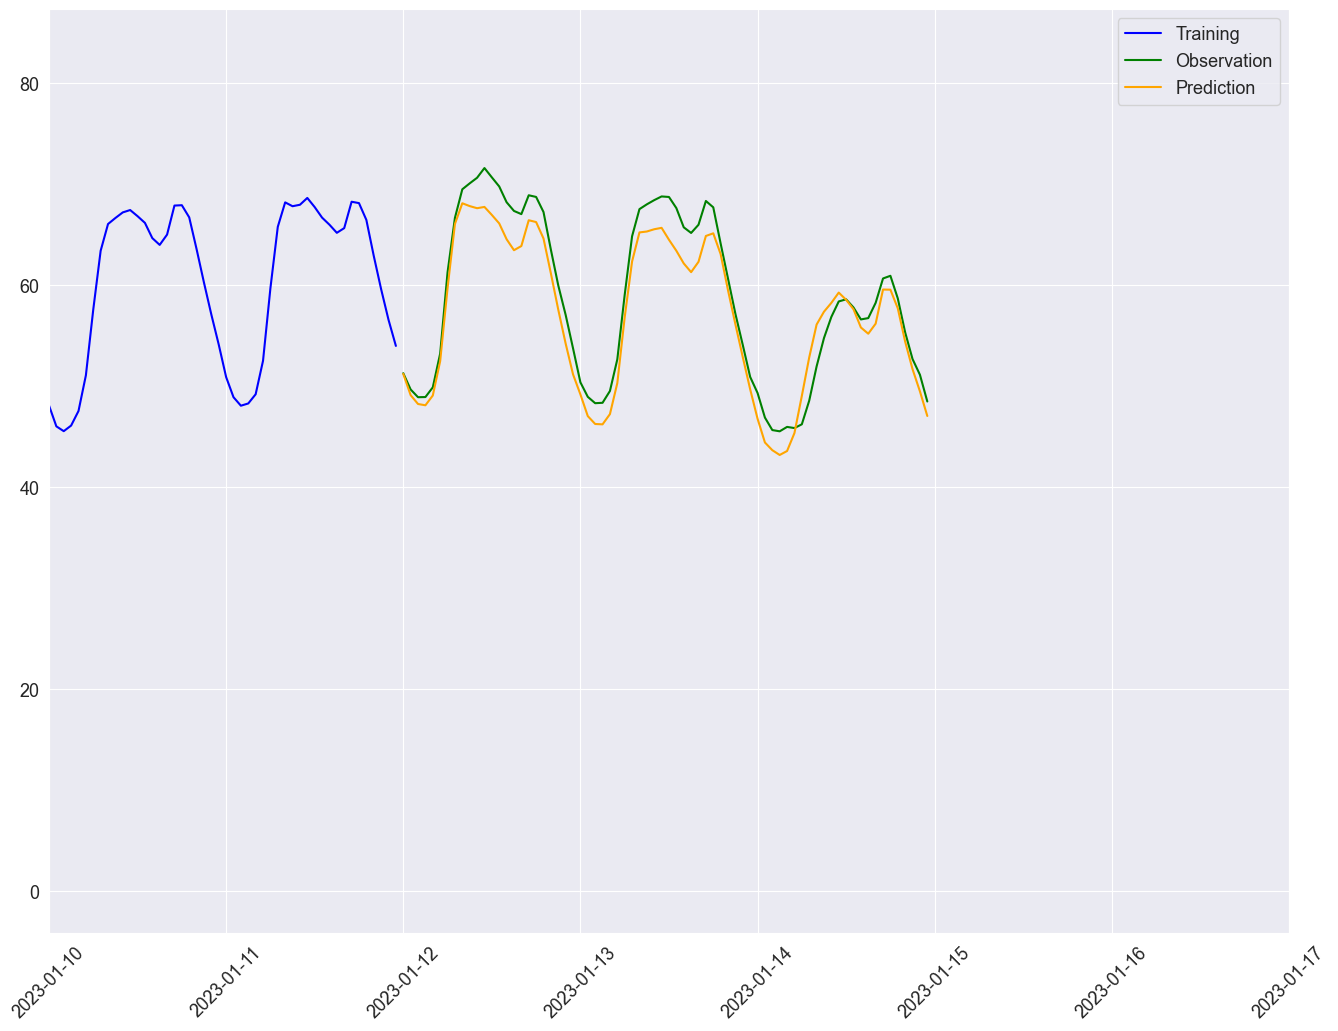

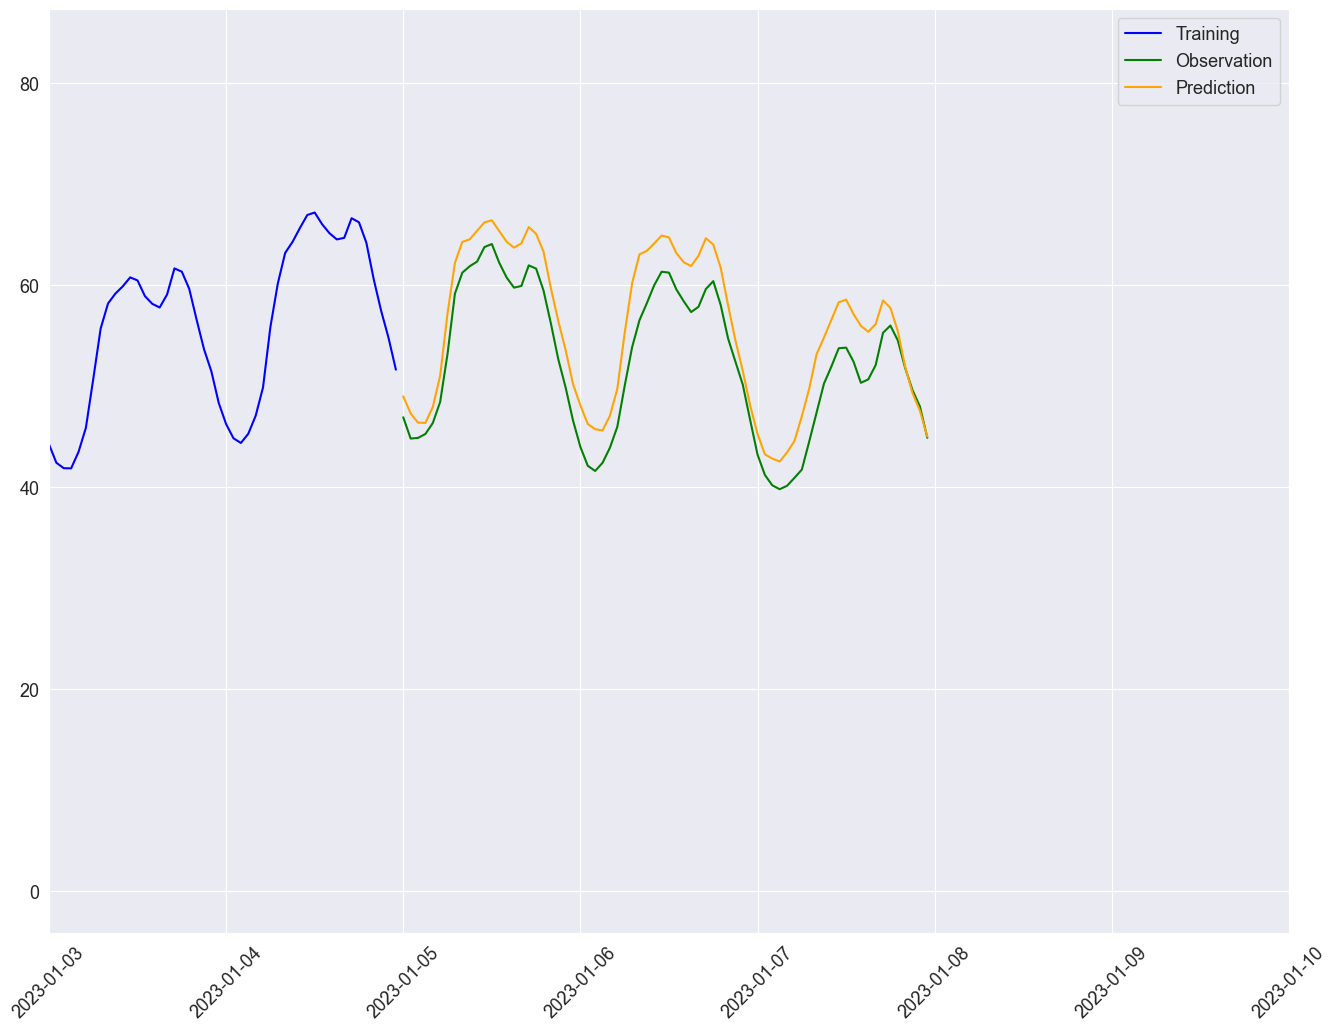

In [107]:
import pandas as pd
from datetime import timedelta

# Trainind Data start date
start_date = pd.to_datetime("2020-01-01")

# Define the thursdays (after the forecast wednesday). It will then be the end date of the training data
end_dates = ["2023-03-23","2023-03-16","2023-03-09","2023-03-02","2023-02-23","2023-02-16","2023-02-09","2023-02-02","2023-01-26","2022-01-20","2023-01-12","2023-01-05"]

residuals = []

for end_date in end_dates:
    end_date = pd.to_datetime(end_date)
    mask = (df.index >= start_date) & (df.index < end_date)
    y = df[mask]
    model = StatsForecastMSTL(season_length=[24,24*7]) 
    fitted_model = model.fit(y=y) 
    
    y_pred = fitted_model.predict(fh=[i for i in range(1,73)]) 
    
    
    start_date_obs = end_date
    end_date_obs = start_date_obs + timedelta(days=3)
    
    mask = (df.index >= start_date_obs) & (df.index < end_date_obs)
    obs = df[mask]
    
    
    import matplotlib.pyplot as plt
    # y.index = y.index.to_timestamp()
    plt.plot(y, color='blue', label='Training')
    
    plt.plot(obs, color='green', label='Observation')
    plt.plot(y_pred, color='orange', label='Prediction')
    plt.legend()
    plt.xticks(rotation=45)
    plt.xlim(pd.to_datetime(end_date-timedelta(days=2)),pd.to_datetime(end_date+timedelta(days=5)))
    plt.show()
    
    res = obs - y_pred
    
    residuals.append(res)
    
    


/Users/elias/Desktop/PTSFC/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


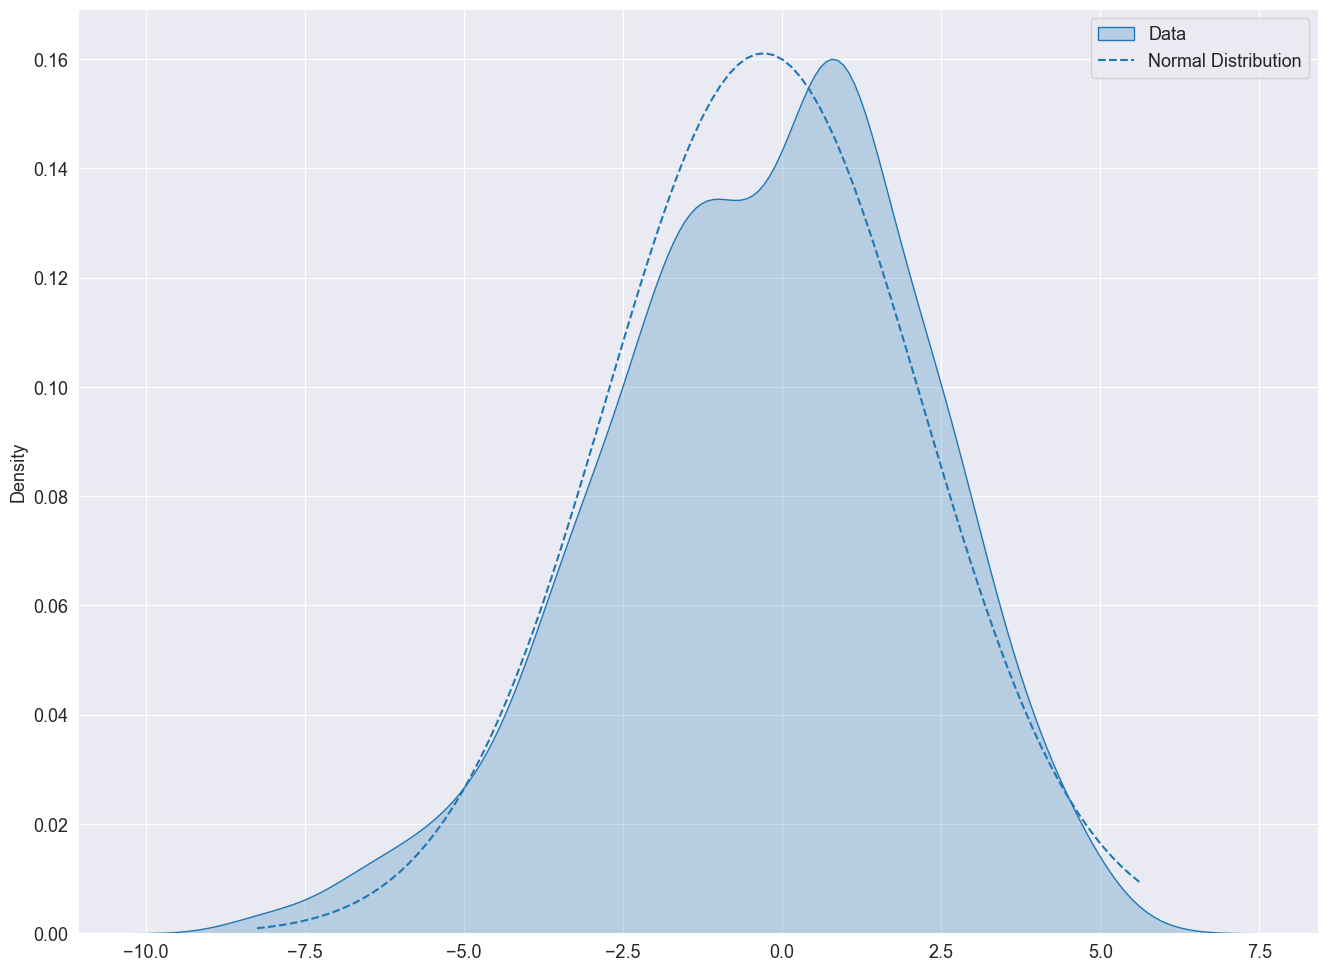

In [109]:
from scipy.stats import norm
res_one_arr = pd.DataFrame()
for res in residuals:
    res_one_arr = pd.concat([res_one_arr, res])
# print(residuals_one_array)

sns.kdeplot(res_one_arr, fill=True, label='Data')

# Add normal dist to plot
normal_dist = norm(loc=np.mean(res_one_arr), scale=np.std(res_one_arr))
x_vals = np.linspace(min(res_one_arr['gesamt']), max(res_one_arr['gesamt']), 100)

# Plot the normal distribution
plt.plot(x_vals, normal_dist.pdf(x_vals), label='Normal Distribution', linestyle='--')

plt.legend()
plt.show()


In [ ]:
print(res_one_arr.mean())
print(res_one_arr.var())

In [ ]:
y_pred2 = fitted_model.predict_quantiles(fh=[i for i in range(1,90)]) 

In [ ]:
print(y_pred.loc["2023-12-08"])

In [ ]:
print(obs.loc["2023-12-08"])

In [ ]:
model.predict_residuals(fh=[i for i in range(1,500)])

In [ ]:
model.residuals_

In [ ]:
object_methods = [method_name for method_name in dir(model)]

In [ ]:
object_methods

In [ ]:
model.predict_residuals(y)

In [ ]:
import seaborn as sns
sns.kdeplot(data=model.predict_residuals(y), fill=True)

In [ ]:
from statistics import mean, median
mean(model.predict_residuals(y)['gesamt'])

In [ ]:
residuals = model.predict_residuals(y)

In [ ]:
from scipy.stats import norm

mean, std_dev = norm.fit(residuals)

In [ ]:
import numpy as np
quantiles = np.quantile(residuals, [.025, .25, .5, .75, .975])

In [ ]:
quantiles

Calculate residuals manually

In [ ]:
residuals = obs - y_pred
sns.kdeplot(residuals, fill=True)

They look much better than the "predicted" residuals. Lets use them instead.